In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# CSV 파일에서 데이터 불러오기
data = pd.read_csv('machine.data.csv')

# 데이터 샘플 보기
print(data.head())

  VendorName ModelName  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP
0    adviser     32/60   125   256   6000   256     16    128  198
1     amdahl    470v/7    29  8000  32000    32      8     32  269
2     amdahl   470v/7a    29  8000  32000    32      8     32  220
3     amdahl   470v/7b    29  8000  32000    32      8     32  172
4     amdahl   470v/7c    29  8000  16000    32      8     16  132


In [2]:
# 시각화를 위해 VendorName과 ModelName 제거
data = data.drop(columns=['VendorName', 'ModelName'])

# 특징과 목표 변수 설정
X = data.drop(columns=['PRP'])
y = data['PRP']


In [3]:
# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# 파이프라인 생성 (표준화 + 선형 회귀)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

In [5]:
# 하이퍼파라미터 튜닝을 위한 GridSearchCV 설정
param_grid = {
    'regressor__fit_intercept': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', LinearRegression())]),
             param_grid={'regressor__fit_intercept': [True, False]},
             scoring='r2')

In [6]:
# 최적의 모델 출력
best_model = grid_search.best_estimator_
print("최적의 모델:", best_model)

최적의 모델: Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])


In [7]:
# 학습 데이터에 대한 성능 평가
y_train_pred = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

In [8]:
# 테스트 데이터에 대한 성능 평가
y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

In [9]:
# 교차 검증 점수
cross_val_mse = -cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error').mean()
cross_val_mae = -cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
cross_val_r2 = cross_val_score(best_model, X, y, cv=5, scoring='r2').mean()

In [10]:
# 성능 지표 표 출력
performance_table = pd.DataFrame({
    'Model': ['Linear Regression', 'Linear Regression', 'Best_estimator', 'Best_estimator', 'Linear Regression', 'Best_estimator'],
    'Data': ['Train', 'Test', 'Train', 'Test', 'Cross Validation', 'Cross Validation'],
    'MSE': [mean_squared_error(y_train, pipeline.fit(X_train, y_train).predict(X_train)),
            mean_squared_error(y_test, pipeline.predict(X_test)),
            train_mse, test_mse,
            cross_val_mse,
            cross_val_mse],
    'MAE': [mean_absolute_error(y_train, pipeline.predict(X_train)),
            mean_absolute_error(y_test, pipeline.predict(X_test)),
            train_mae, test_mae,
            cross_val_mae,
            cross_val_mae],
    'R^2': [r2_score(y_train, pipeline.predict(X_train)),
            r2_score(y_test, pipeline.predict(X_test)),
            train_r2, test_r2,
            cross_val_r2,
            cross_val_r2]
})

# 표 출력
print(performance_table)

               Model              Data          MSE        MAE       R^2
0  Linear Regression             Train  3117.658905  35.122006  0.837828
1  Linear Regression              Test  5633.068156  48.068801  0.889346
2     Best_estimator             Train  3117.658905  35.122006  0.837828
3     Best_estimator              Test  5633.068156  48.068801  0.889346
4  Linear Regression  Cross Validation  6383.656697  43.378262  0.616234
5     Best_estimator  Cross Validation  6383.656697  43.378262  0.616234


In [11]:
# 성능 지표 시각화
metrics_mse = ['Train MSE', 'Test MSE', 'Cross Val MSE']
metrics_mae = ['Train MAE', 'Test MAE', 'Cross Val MAE']
metrics_r2 = ['Train R2', 'Test R2', 'Cross Val R2']

values_mse = [
    mean_squared_error(y_train, pipeline.predict(X_train)),
    mean_squared_error(y_test, pipeline.predict(X_test)),
    cross_val_mse
]

values_mae = [
    mean_absolute_error(y_train, pipeline.predict(X_train)),
    mean_absolute_error(y_test, pipeline.predict(X_test)),
    cross_val_mae
]

values_r2 = [
    r2_score(y_train, pipeline.predict(X_train)),
    r2_score(y_test, pipeline.predict(X_test)),
    cross_val_r2
]

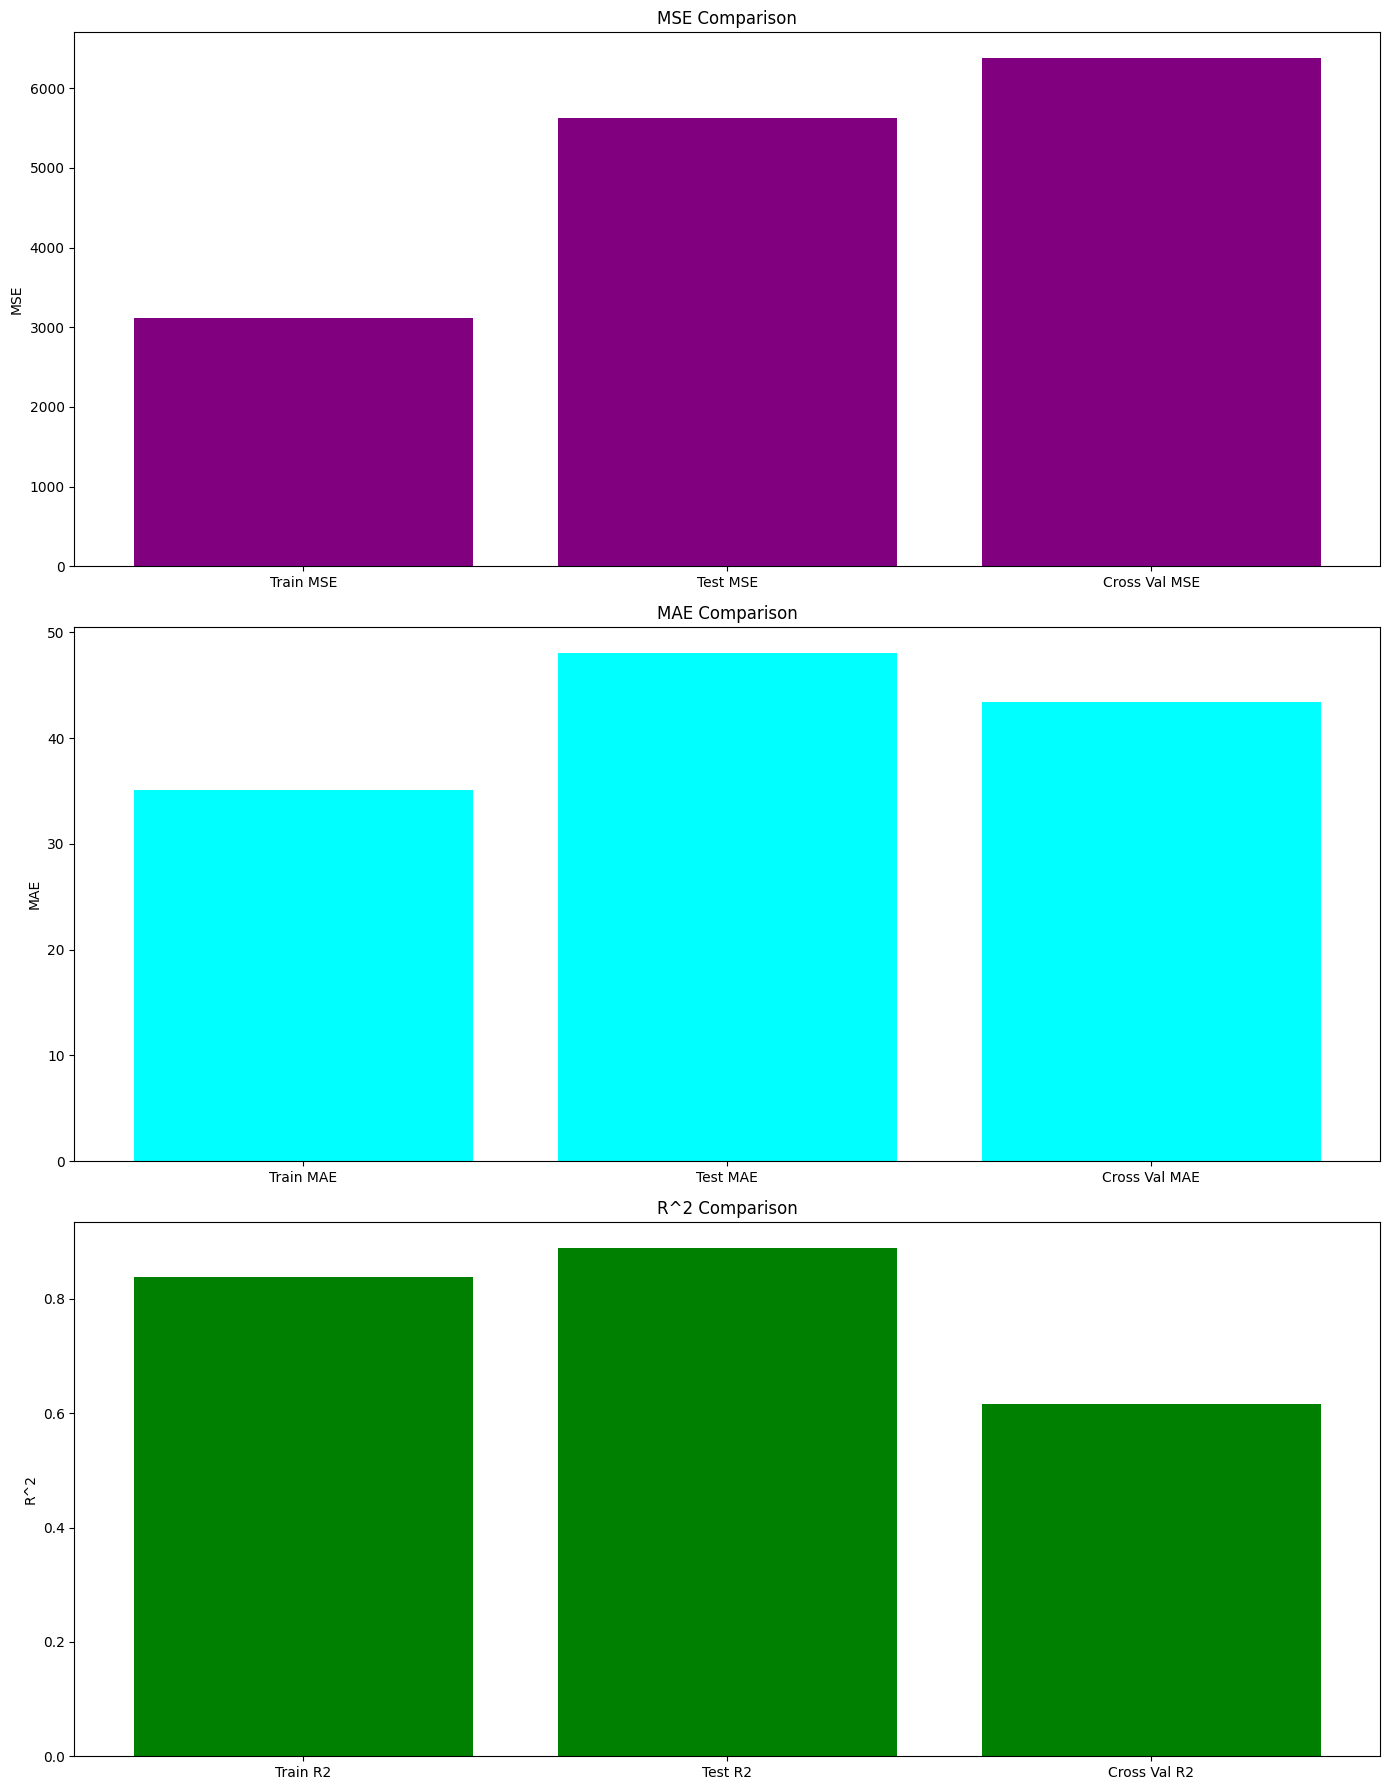

In [12]:
# 바 차트 시각화
fig, axs = plt.subplots(3, 1, figsize=(14, 18))

axs[0].bar(metrics_mse, values_mse, color='purple')
axs[0].set_title('MSE Comparison')
axs[0].set_ylabel('MSE')

axs[1].bar(metrics_mae, values_mae, color='cyan')
axs[1].set_title('MAE Comparison')
axs[1].set_ylabel('MAE')

axs[2].bar(metrics_r2, values_r2, color='green')
axs[2].set_title('R^2 Comparison')
axs[2].set_ylabel('R^2')

fig.tight_layout()
plt.show()

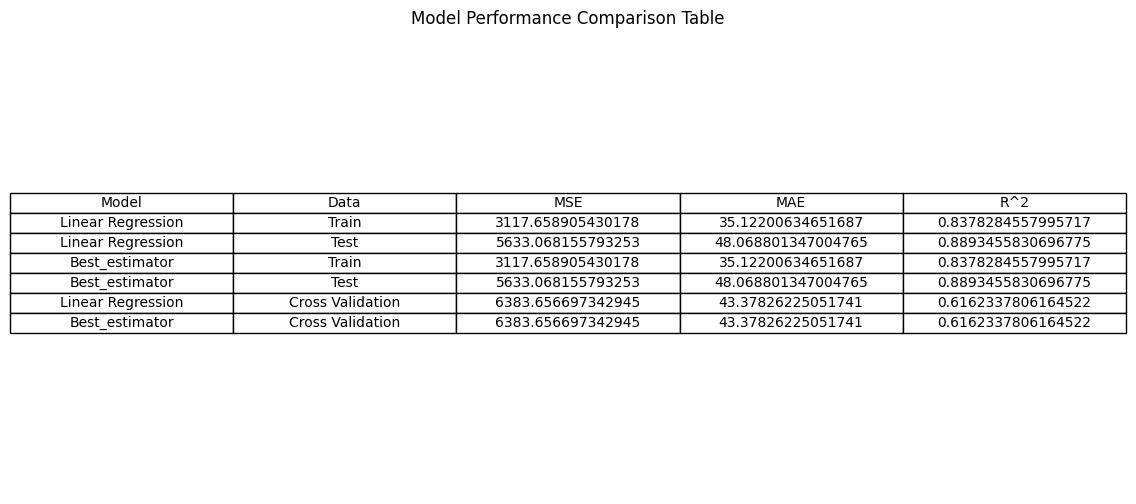

In [13]:
# 성능 지표 표를 그래픽으로 저장
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=performance_table.values, colLabels=performance_table.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # 표 크기 조정
plt.title("Model Performance Comparison Table")
plt.show()